In [1]:
from rtree import index
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import math
from scipy.optimize import leastsq
import matplotlib
import sys

In [35]:
L=10**10
times=10**3
r0  = 100
delta = r0
maxnode = 1000
C = 1
sequence = []; 
nodelist = {}
#for C in np.logspace(-5,3,100):

# initiate

In [3]:
def initiate(L,radius,C): #k is not used
    coordinate = np.ones(2)*L/2.0
    nodelist = {(coordinate[0],coordinate[1]):{1:1, 3:1, 5:0.0, 6:0, 7:1}}  ####!!!这里虽然仍叫Nodelist，但实际上是LatticeList，
    #所以在后面的计算时须要小心！！~~
    #坐标(i,j)作为Index，  1序号(第几个成功落点的点), 3degree, 5distance2center, 6timestamp for survival， 7the number of people in this unit
    index2coor = {1:(coordinate[0],coordinate[1])}
    # Create 2D index
    idx = index.Index()
    for key in nodelist:
        idx.insert(  nodelist[key][1],list(np.r_[coordinate,coordinate])  ) 
    limitt = np.r_[coordinate - radius,coordinate + radius] #also one dimension array
    # nodelist: a list of nodes~~  idxnd: Rtree indices~~  limitt: Rectangle boundary：xmin,ymin,  xmax,ymax
    ksequence = []
    ksequence.append(1) #这里只记录每个格点上的人数，所以在这里面C没有必要引入，后面C的影响 都放在choosenode里来处理
    return (nodelist,idx,limitt,index2coor,ksequence)

In [4]:
coordinate = np.ones(2)*L/2.0
coordinate

array([  5.00000000e+09,   5.00000000e+09])

In [17]:
nodelist = {(coordinate[0],coordinate[1]):{1:1,3:1,5:0.0,6:0,7:0}}
nodelist[(5000000000.0, 5000000000.0)]

{1: 1, 3: 1, 5: 0.0, 6: 0, 7: 0}

In [6]:
index2coor = {1:(coordinate[0],coordinate[1])}
index2coor

{1: (5000000000.0, 5000000000.0)}

In [16]:
idx = index.Index()
for key in nodelist:
    #nodelist[key]:{1: 1, 3: 1, 5: 0.0, 6: 0, 7: 0}
    idx.insert(  nodelist[key][1],list(np.r_[coordinate,coordinate])  )
    print(  nodelist[key][1],list(np.r_[coordinate,coordinate])  )

1
1 [5000000000.0, 5000000000.0, 5000000000.0, 5000000000.0]


In [20]:
limitt =  np.r_[coordinate - r0,coordinate + r0] 
limitt

array([  4.99999990e+09,   4.99999990e+09,   5.00000010e+09,
         5.00000010e+09])

In [21]:
ksequence = []
ksequence.append(1) 
ksequence

[1]

In [19]:
nodelist,idx,limitt,index2coor,sequence = initiate(L,r0,C)
nodelist,idx,limitt,index2coor,sequence

({(5000000000.0, 5000000000.0): {1: 1, 3: 1, 5: 0.0, 6: 0, 7: 1}},
 array([  4.99999990e+09,   4.99999990e+09,   5.00000010e+09,
          5.00000010e+09]),
 {1: (5000000000.0, 5000000000.0)},
 [1])

# onestep

In [36]:
totpop = 1  #这种情况下一定得注意总人数不是len(nodelist)~~那个是总‘建成面积’
tstep = 1
time = 1  #R_t~t^中的t
tempP = 1
tempT = 1
T = 2

In [4]:
def onestep(nodelist,index2coor,idx,time,L,radius,C,limitt,totpop,ksequence):
    ss = 1
    for i in range(2):
        ss = ss*(limitt[i+2]-limitt[i])
    ss *= C
    ss += totpop
    #total attaction
    locallambda = ss/(L**2*C + totpop)
    time += random.expovariate(locallambda)  #time就是所谓的落点的时间R_t~t^xxx中的t~~   make the time real....

    two,flag,ksequence = choosenode(nodelist,limitt,C,ksequence,totpop)  
    i = two[0]; j = two[1]  #这是它们的坐标

    intersection = list(  idx.intersection( [i-radius,j-radius, i+radius,j+radius] )  )  #用框和之前的点来进行Intersect
    withincircle = 0    
    if len(intersection) > 0:  #this node (i,j) can survive ##为什么Intersection时会出现3L？明明只有两个点

        for key in intersection:  
#            print i,j,key,idx,list(intersection),index2coor[key],nodelist,'\n\n\n'
            if np.linalg.norm(np.array(index2coor[key]) - np.array([i,j])) <= radius:  #intersection是个方形,还是看圆形区域内
                withincircle += 1
                continue
                
        if flag==1: #落到了已有格子上
            nodelist[(i,j)][7] += 1
            nodelist[(i,j)][3] += 1
            ksequence[ nodelist[(i,j)][1]-1 ] += 1
            totpop += 1   
            
        elif  withincircle > 0  and  flag==0: #落到了空白格子上
            totpop += 1  ##        
            nodelist[(i,j)] = {1:len(nodelist)+1,3:1,5:np.linalg.norm(np.array([i,j])-L/2),6:time,7:1} #最终版

            index2coor[len(nodelist)] = (i,j)

            newpoint = [i,j]
            idx.insert( len(nodelist), np.r_[newpoint, newpoint] )  
#==============================================================================
            ksequence.append( nodelist[(i,j)][3] )
#==============================================================================
            
            for i in range(2):  #2 is the dimension 'd'
                limitt[i]   = round(min(limitt[i],newpoint[i]-radius))
                limitt[i+2] = round(max(limitt[i+2],newpoint[i]+radius)) #相应维另一点之x,y,z...(共d个)坐标矣
    return nodelist,index2coor,idx,time,limitt,totpop,ksequence


In [ ]:
while tstep < times  and  totpop < maxnode:#终止条件
    nodelist,index2coor,idx,time,limitt,totpop,sequence = onestep(nodelist,index2coor,idx,time,L,radius,C,limitt,totpop,sequence)

# Choose Node

In [14]:
white = ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1])-len(nodelist) )*C
white

40000.0

In [21]:
total = sum(sequence) + ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1]) )*C 
rnd = random.random()*total
total,rnd

(40001.0, 14614.219065299942)

In [ ]:
while 1:
    ii = int( random.random()*(limitt[2]-limitt[0])   + limitt[0] )
    jj = int( random.random()*(limitt[3]-limitt[1])   + limitt[1] )
    #int??????amazing
    if (ii,jj) not in nodelist:
        return (ii,jj),0,ksequence  #flag=0,表示落了个新的空白位置

In [24]:
A = np.array([1,1,1,1])+C
B = np.cumsum(A)
A,B

(array([2, 2, 2, 2]), array([2, 4, 6, 8], dtype=int32))

In [35]:
ind = np.nonzero([0,1,2,4])  
ind

(array([1, 2, 3], dtype=int32),)

In [33]:
# 第一个节点
C = 1
A = np.array([1]) + C
B = np.cumsum(A)
rnd = random.random()*( 1 + )
ind = np.nonzero(B<)


array([2], dtype=int32)

In [5]:
def choosenode(nodelist,limitt,C,ksequence,totpop):
    white = ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1])-len(nodelist) )*C#未落点的Limit框中空白格点的吸引力
    rnd = random.random()*( sum(ksequence)+len(nodelist)*C + white ) 
#    print 'sum,totpop', sum(ksequence),totpop #they two are the same prove the process is correct
    if rnd> sum(ksequence)+len(nodelist)*C:  #说明选到了空白区域，然后就随机落点，直到它落到一个空白点上（是否存活在主程序中判断）
        while 1:
            ii = int( random.random()*(limitt[2]-limitt[0])   + limitt[0] )
            jj = int( random.random()*(limitt[3]-limitt[1])   + limitt[1] )
            if (ii,jj) not in nodelist:
                return (ii,jj),0,ksequence  #flag=0,表示落了个新的空白位置
    else:  #落到了非空格子上 
        A = np.array(ksequence)+C
        B = np.cumsum(A)
        ind = np.nonzero(B<rnd)
        if len(ind[0])==0:  #比第一个节点都小就会返回空，所以用长度来判，然后位置是第1个节点（1）
            pos = 1
        else:
            pos = ind[0][-1]+1  #因从0开始返回，故须+1， 其序始同于模型设定
        return index2coor[pos],1,ksequence    #flag=1,表示落到了从前的位置上     

# create a city

In [37]:
nodelist,idx,limitt,index2coor,sequence = initiate(L,r0,C)

In [38]:
while tstep < times  and  totpop < maxnode:
    nodelist,index2coor,idx,time,limitt,totpop,sequence = onestep(nodelist,index2coor,idx,time,L,r0,C,limitt,totpop,sequence)

In [39]:
nodelist

{(4999999246, 5000000699): {1: 901,
  3: 1,
  5: 1028.1619522234812,
  6: 1.0205077431212074e+17,
  7: 1},
 (4999999259, 4999999817): {1: 626,
  3: 1,
  5: 763.26273327079184,
  6: 9.0292846058919e+16,
  7: 1},
 (4999999268, 5000000627): {1: 833,
  3: 1,
  5: 963.82207901666163,
  6: 9.989803996864574e+16,
  7: 1},
 (4999999274, 4999999891): {1: 629,
  3: 1,
  5: 734.13690821263037,
  6: 9.069455660880523e+16,
  7: 1},
 (4999999280, 5000000207): {1: 821,
  3: 1,
  5: 749.16553577964328,
  6: 9.931096545732493e+16,
  7: 1},
 (4999999287, 5000000190): {1: 874,
  3: 1,
  5: 737.8814267888846,
  6: 1.0130242856556933e+17,
  7: 1},
 (4999999289, 4999999743): {1: 795,
  3: 1,
  5: 756.02248643806888,
  6: 9.822210371993765e+16,
  7: 1},
 (4999999294, 5000000422): {1: 881,
  3: 1,
  5: 822.50835862014196,
  6: 1.0145813839055448e+17,
  7: 1},
 (4999999302, 5000000236): {1: 708,
  3: 1,
  5: 736.81748079154579,
  6: 9.473843810075325e+16,
  7: 1},
 (4999999303, 5000000105): {1: 911,
  3: 1,
  

In [40]:
index2coor

{1: (5000000000.0, 5000000000.0),
 2: (5000000038, 4999999961),
 3: (5000000102, 5000000016),
 4: (5000000010, 4999999905),
 5: (5000000180, 4999999987),
 6: (5000000065, 4999999903),
 7: (5000000040, 4999999996),
 8: (5000000212, 5000000042),
 9: (5000000198, 5000000077),
 10: (4999999977, 4999999904),
 11: (5000000179, 4999999923),
 12: (5000000170, 5000000022),
 13: (5000000115, 4999999945),
 14: (4999999933, 4999999858),
 15: (5000000024, 5000000070),
 16: (5000000160, 5000000022),
 17: (5000000087, 5000000122),
 18: (4999999973, 5000000137),
 19: (5000000067, 4999999987),
 20: (4999999901, 5000000191),
 21: (4999999806, 5000000205),
 22: (5000000271, 5000000129),
 23: (5000000058, 4999999973),
 24: (5000000291, 5000000140),
 25: (5000000021, 4999999928),
 26: (5000000022, 5000000101),
 27: (4999999775, 5000000233),
 28: (5000000043, 5000000006),
 29: (5000000056, 5000000133),
 30: (5000000105, 5000000101),
 31: (5000000165, 5000000104),
 32: (4999999768, 5000000305),
 33: (5000000

In [41]:
totpop

1000

In [42]:
sequence

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


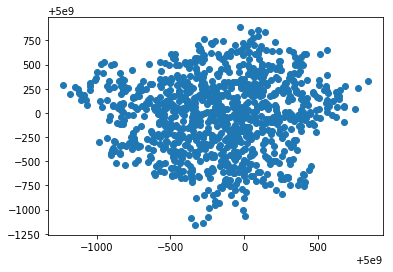

In [65]:
%matplotlib inline

import matplotlib.pyplot as plt  
x = index2coor
a = []
m = []
n = []
for k,v in index2coor.items():
    a.append(v)
for i in a:
    m.append(i[0])
    n.append(i[1])
plt.scatter(m,n)
plt.show()